# $\rho'$ analysis notes

### Data scheme

In [71]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import pandas as ps
import awkward

ccup9_2015_my_test = r"D:\GoogleDrive\Job\cern\Alice\analysis\dev\grid\selection\RhoPrime\macro\AnalysisResults.root"
ccup9_2015 = r'D:\GoogleDrive\Job\cern\Alice\analysis\data\RhoPrime\2015\4Prongs2015oLx.root'
ccup9_2015_train = r'D:\GoogleDrive\Job\cern\Alice\analysis\data\RhoPrime\2015\4Prongs2015oTrain.root'
test = r'D:\GoogleDrive\Job\cern\Alice\analysis\data\RhoPrime\2015\4merge\000246148\000246148.root'
testNew = r'D:\GoogleDrive\Job\cern\Alice\analysis\data\test\246148new.root'


events = uproot.open(ccup9_2015_train)['4Prongs/events']
events.show()
# mycache = uproot.ArrayCache(1024*1024 * 10)
data = events.arrays('*', namedecode="utf-8")
# data = events.lazyarrays('*', namedecode="utf-8")

print(events.name, events.title, events.numentries, data['nTracks'].sum())

RunNum                     (no streamer)              asdtype('>i4')
PeriodNumber               (no streamer)              asdtype('>u4')
OrbitNumber                (no streamer)              asdtype('>u4')
BunchCrossNumber           (no streamer)              asdtype('>u2')
Mass                       (no streamer)              asdtype('>f4')
Pt                         (no streamer)              asdtype('>f4')
Q                          (no streamer)              asdtype('>i2')
Rapidity                   (no streamer)              asdtype('>f4')
Phi                        (no streamer)              asdtype('>f4')
ZNAenergy                  (no streamer)              asdtype('>f4')
ZNCenergy                  (no streamer)              asdtype('>f4')
ZPAenergy                  (no streamer)              asdtype('>f4')
ZPCenergy                  (no streamer)              asdtype('>f4')
VtxX                       (no streamer)              asdtype('>f4')
VtxY                       (no str

### Run numbers from 2015o period

245145 243
245146 283
245151 31
245152 35
245231 63
245232 140
245259 102
245345 884
245346 154
245347 781
245349 868
245353 1943
245396 779
245397 900
245401 728
245407 2428
245409 1750
245410 585
245411 2042
245441 1028
245446 157
245450 320
245453 1297
245496 458
245501 1143
245504 766
245505 420
245507 2832
245540 383
245542 648
245543 1561
245544 124
245545 125
245554 2333
245692 895
245702 132
245705 412
245775 2245
245793 1419
245829 569
245831 953
245833 222
245923 41
245949 320
245952 1868
245954 1434
246001 942
246003 287
246012 566
246037 209
246042 653
246048 80
246049 944
246052 60
246087 2889
246089 142
246115 53
246151 571
246152 130
246153 1584
246178 176
246180 397
246181 615
246182 837
246185 101
246222 927
246225 543
246272 1107
246275 521
246276 324
246431 325
246434 760
246488 1260
246493 503
246495 181
246750 350
246751 317
246757 123
246758 437
246759 39
246760 471
246763 279
246765 171
246766 67
246805 508
246807 522
246809 998
246844 236
246845 354
246846 247
2

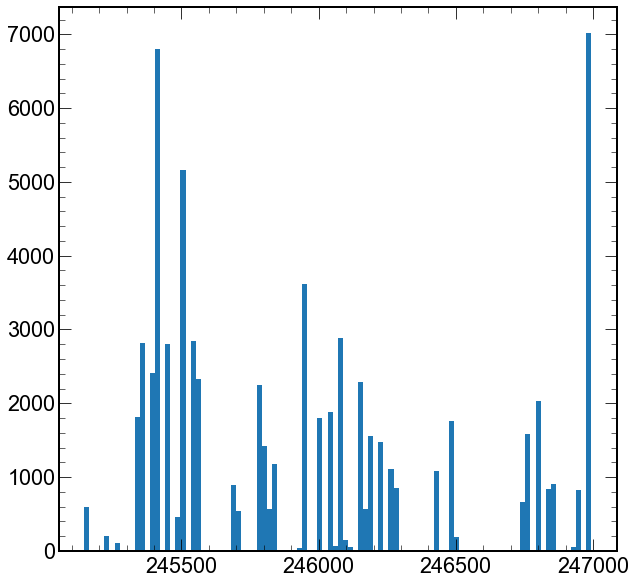

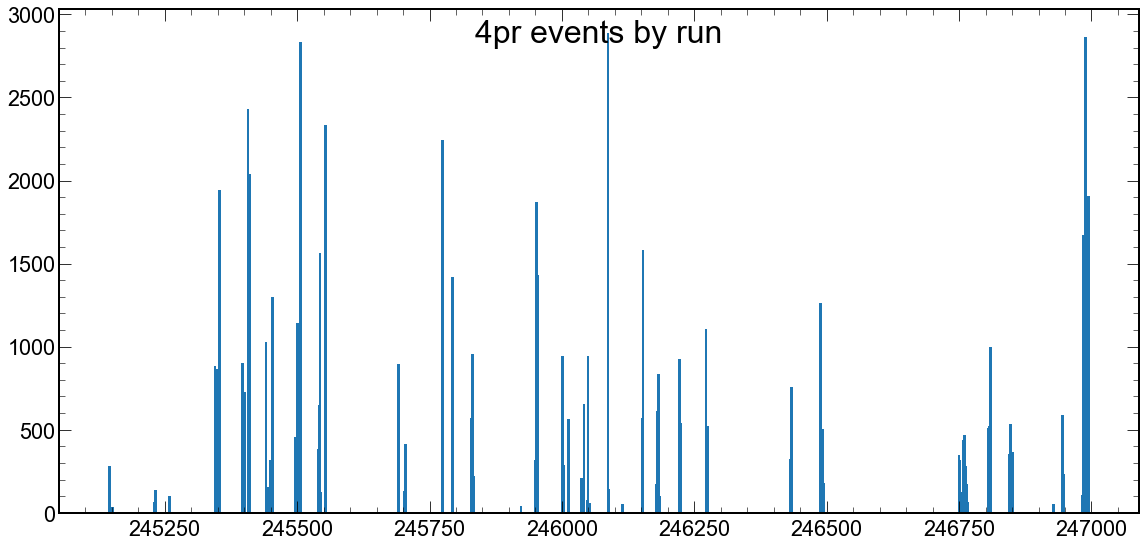

In [229]:
# print (np.unique(data['RunNum']))

runs = data['RunNum'][GoodEvents]

counts = plt.hist(runs,bins=len(np.unique(runs)))

bins = []
counts = []

for run in np.unique(runs):
    bins.append(run)
    counts.append((data['RunNum'][GoodEvents] == run).sum())
    print(run, (data['RunNum'][GoodEvents] == run).sum())

plt.style. use(hep.style.ROOT)
fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle('4pr events by run', fontsize=32)
ax.bar(bins,counts,width=5 )
# ax.set_xticks(bins)
# ax.set_xticklabels(bins,rotation=90, rotation_mode="anchor", ha="right")
plt.show()



## Selection criteria:

These criteria were applied on the selection stage:

Events:

    * Zero cumulative charge 
    * at least four tracks satisfy track selection criteria.
    
Tracks:

    * Has Point On inner or outer ITS Layer
    * dca1 < 2 and dca0 < (0.0182 + 0.0350 / TMath::Power(trk->Pt(), 1.01));

## Analysis criteria:

These criteria will apply for the selected data:

    * numbers of ITS clusters more then 3
    * not ITS SA


In [72]:
select    = (data['T_ITSNCls'] >= 3) #* (~newT_ITSsa)

selectTpc = data['T_TPCRefit'] * (data['T_TPCNCls'] > 50) * (np.abs(data['T_NumberOfSigmaTPCPion']) < 3)

def GetGoodEvents(TrackNum=4, ChargeEqualCondition=True, charge=0, WithGoodNTpcTracks=0):
#     GoodEvents = np.argwhere(select.sum()==TrackNum).flatten() # get events with 4 good tracks
    GoodEvents = np.argwhere(data['T_ITSNCls'].counts==TrackNum).flatten() # get events with 4 good tracks
    
    # get number of events with more than 'WithGoodNTpcTracks' tracks that satisfied 'selectTpc' criteria
    GoodEventsTpc = np.argwhere(selectTpc.sum() >= WithGoodNTpcTracks).flatten()

    # add at least n tracks with tpc to selected
    GoodEvents = np.intersect1d(GoodEvents,GoodEventsTpc).flatten()
    
    # get events that have total charge from 4 tracks 
    if ChargeEqualCondition:
        GoodEvents = GoodEvents[np.argwhere(data['T_Q'][select][GoodEvents].sum()==charge).flatten()].flatten()  # get good events witch total charge zero
    else:
        GoodEvents = GoodEvents[np.argwhere(data['T_Q'][select][GoodEvents].sum()!=charge).flatten()].flatten()  # get good events witch total charge non zero

    return GoodEvents

## Data validation

### Duplicates

Cause of some reasons AliESD could contains the same track few times.

![img](https://sun9-69.userapi.com/c855620/v855620379/242fba/B1cMRF7RoH0.jpg)

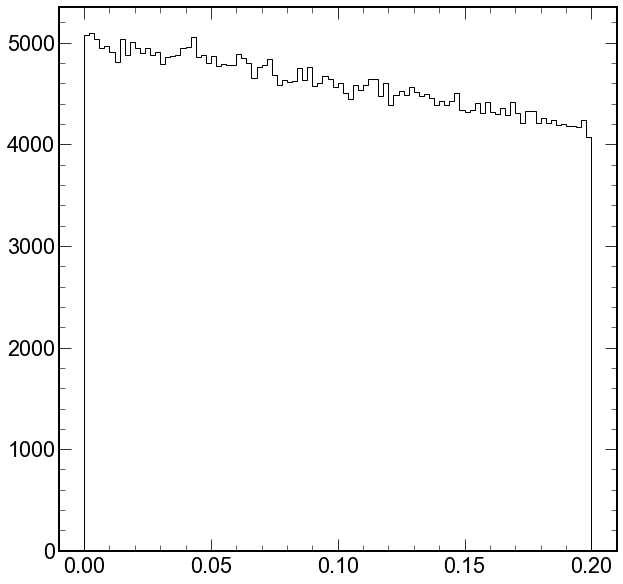

In [8]:
import math
differences = []
# GoodEvents = GetGoodEvents(TrackNum=4, WithGoodNTpcTracks=0)
# GoodEvents = GetUniqueGoodEvents()
entries = len(data['T_Px'][select])
ddpx = data['T_Px'][select]
ddpy = data['T_Py'][select]
ddpz = data['T_Pz'][select]
for event in range(entries):
    dpx = ddpx[event]
    dpy = ddpx[event]
    dpz = ddpx[event]
    N = len(dpx)
    for n in range(N):
        for j in range(n+1,N):
             
            differences.append(math.sqrt((dpx[n]-dpx[j])**2 + (dpy[n]-dpy[j])**2 + (dpz[n]-dpz[j])**2))

counts, bins = np.histogram(differences,bins=100, range=(0,0.2))
plt.style.use(hep.style.ROOT)
_ = plt.hist(differences, bins=bins, histtype='step', color='black')



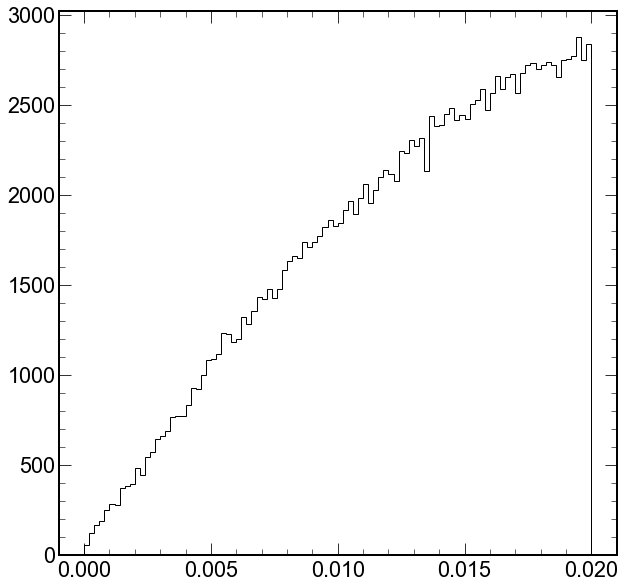

In [9]:
import math
differences = []
# GoodEvents = GetGoodEvents(TrackNum=4, WithGoodNTpcTracks=0)
# GoodEvents = GetUniqueGoodEvents()
entries = len(data['T_Dca0'][select])
dca0 = data['T_Dca0'][select]
dca1 = data['T_Dca1'][select]
for event in range(entries):
    ddca0 = dca0[event]
    ddca1 = dca1[event]
    N = len(ddca0)
    for n in range(N):
        for j in range(n+1,N):
            differences.append(math.sqrt((ddca0[n]-ddca0[j])**2 + (ddca1[n]-ddca1[j])**2))

counts, bins = np.histogram(differences,bins=100, range=(0,0.02))
plt.style.use(hep.style.ROOT)
_ = plt.hist(differences, bins=bins, histtype='step', color='black')

## Show any parameter

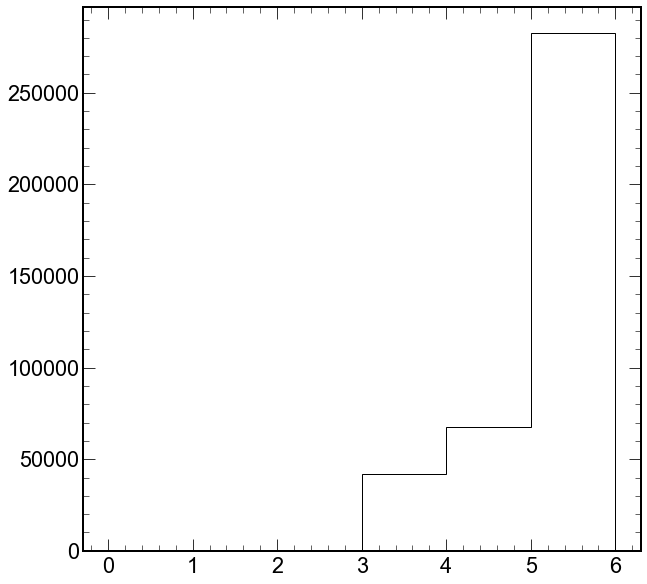

In [10]:
param = 'T_ITSNCls'
# dataParam = data[param][~newT_ITSsa].flatten() # tracks
dataParam = data[param].flatten() # events

counts, bins = np.histogram(dataParam,bins=6, range=(0,6))
plt.style.use(hep.style.ROOT)
_= plt.hist(dataParam, bins=bins, histtype='step', color='black', label=f'Entries {np.sum(counts)}')

## Pt

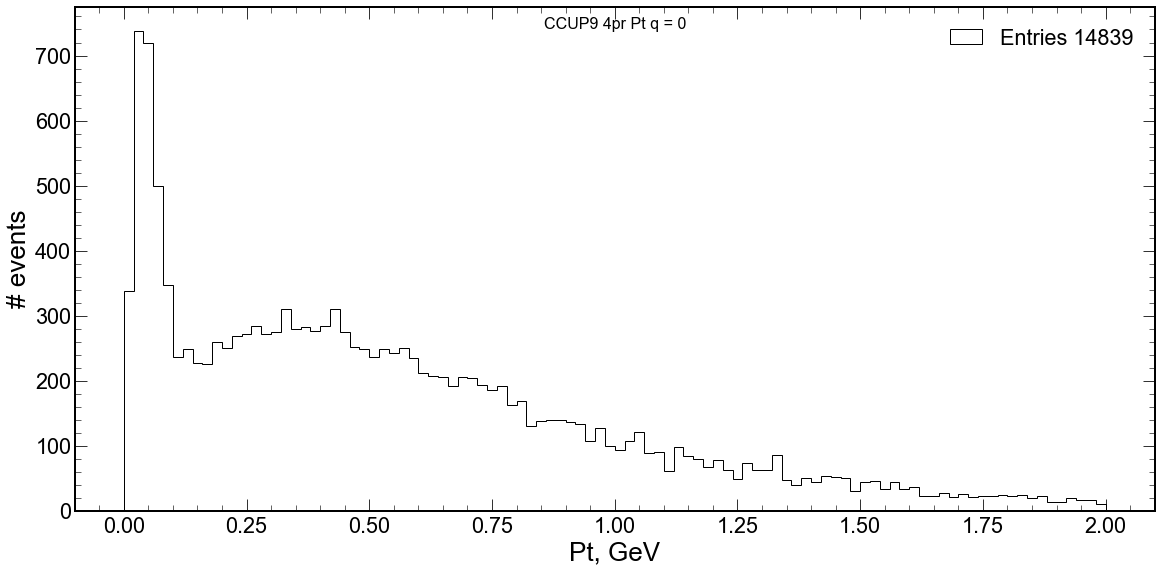

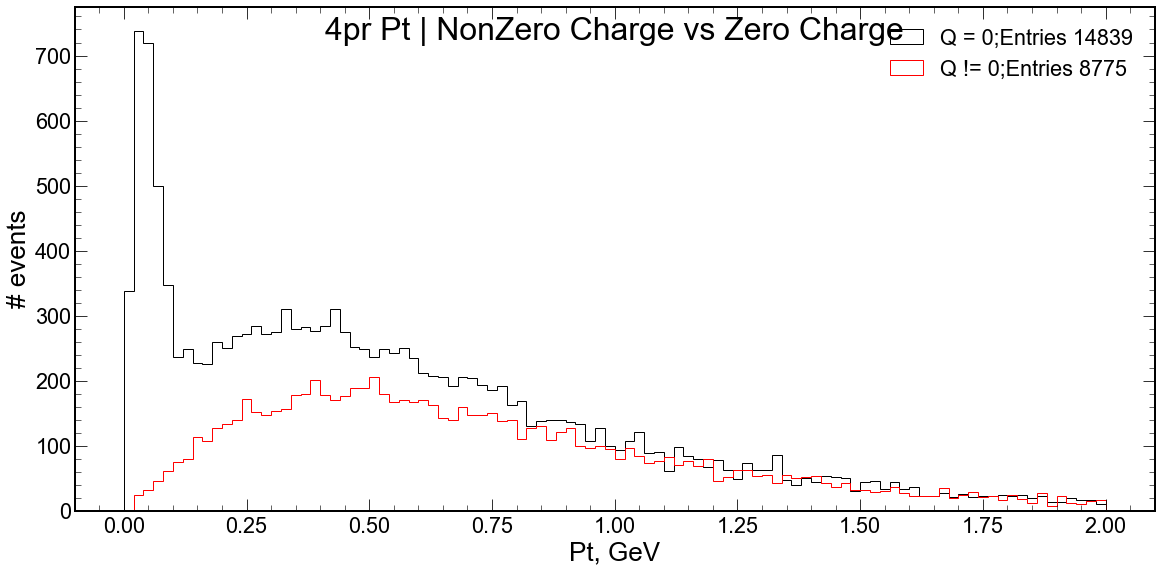

In [73]:
def GetPt(Draw=True, ChargeEqualCondition=True):
    pxg = data['T_Px'][select][GoodEvents]
    pyg = data['T_Py'][select][GoodEvents]
    
    pt = np.sqrt(pxg.sum()**2  + pyg.sum()**2)
    
    if Draw:
        counts, bins = np.histogram(pt,bins=100, range=(0,2))
        fig = plt.figure(figsize=(15, 7))
        ax = fig.add_axes([0,0,1,1])
        fig.suptitle('CCUP9 4pr Pt q = 0', fontsize=16)
        if ChargeEqualCondition:
            fig.suptitle('CCUP9 4pr Pt q = 0', fontsize=16)
        else:
            fig.suptitle('CCUP9 4pr Pt q != 0', fontsize=16)
            
        plt.style.use(hep.style.ROOT)
        ax.hist(pt, bins=bins, histtype='step', color='black', label=f'Entries {np.sum(counts)}')
        plt.xlabel('Pt, GeV')
        plt.ylabel('# events')
        ax.legend()
    else:
        return pt
    
GoodEvents = GetGoodEvents(WithGoodNTpcTracks=0)
GetPt()

## Zero charge vs Non zero charge
fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'4pr Pt | NonZero Charge vs Zero Charge', fontsize=32)
plt.style.use(hep.style.ROOT)
GoodEvents = GetGoodEvents()
ptzq = GetPt(Draw=False)
counts, bins = np.histogram(ptzq, bins=100, range=(0,2))
_ = ax.hist(ptzq, bins=bins, color='black', histtype='step', label=f'Q = 0;Entries {np.sum(counts)}')
GoodEvents = GetGoodEvents(ChargeEqualCondition=False)
ptnzq = GetPt(Draw=False,ChargeEqualCondition=False)
counts, bins = np.histogram(ptnzq, bins=100, range=(0,2))
_ = ax.hist(ptnzq, bins=bins, color='red', histtype='step', label=f'Q != 0;Entries {np.sum(counts)}')
plt.xlabel('Pt, GeV')
plt.ylabel('# events')
ax.legend()

## Mass

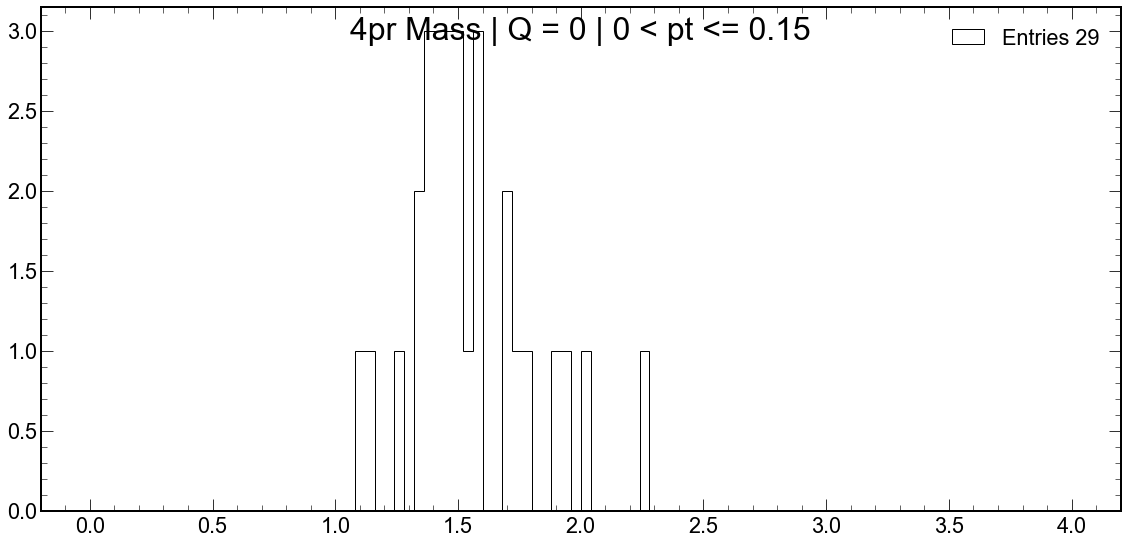

In [66]:
def GetMass(ptMin=0, ptMax=0.15, Draw=True, ChargeEqualCondition=True):
    pxg = data['T_Px'][select][GoodEvents]
    pyg = data['T_Py'][select][GoodEvents]
    pzg = data['T_Pz'][select][GoodEvents]
    massPion = np.full(pxg.shape[0], 0.140)
    pt = np.sqrt(pxg.sum()**2  + pyg.sum()**2)

    Energy0 = np.sqrt(massPion**2 + pxg[:,0]**2 + pyg[:,0]**2 + pzg[:,0]**2)
    Energy1 = np.sqrt(massPion**2 + pxg[:,1]**2 + pyg[:,1]**2 + pzg[:,1]**2)
    Energy2 = np.sqrt(massPion**2 + pxg[:,2]**2 + pyg[:,2]**2 + pzg[:,2]**2)
    Energy3 = np.sqrt(massPion**2 + pxg[:,3]**2 + pyg[:,3]**2 + pzg[:,3]**2)

    Energy = Energy0 + Energy1 + Energy2 + Energy3
    
    Mass = np.sqrt(Energy**2 - pxg.sum()**2 - pyg.sum()**2 - pzg.sum()**2)[(pt>ptMin)*(pt<=ptMax)]
    
    if Draw:
        fig = plt.figure(figsize=(15, 7))
        ax = fig.add_axes([0,0,1,1])
        if ChargeEqualCondition:
            fig.suptitle(f'4pr Mass | Q = 0 | {ptMin} < pt <= {ptMax}', fontsize=32)
        else:
            fig.suptitle(f'4pr Mass | Q != 0 | {ptMin} < pt <= {ptMax}', fontsize=32)
        plt.style.use(hep.style.ROOT)
        counts, bins = np.histogram(Mass, bins=100, range=(0,4))
        _ = ax.hist(Mass, bins=bins, color='black', histtype='step', label=f'Entries {np.sum(counts)}')
        ax.legend()
    else:
        return Mass
GoodEvents = GetGoodEvents()     
GetMass()

## Mass - pt - charge distirbution

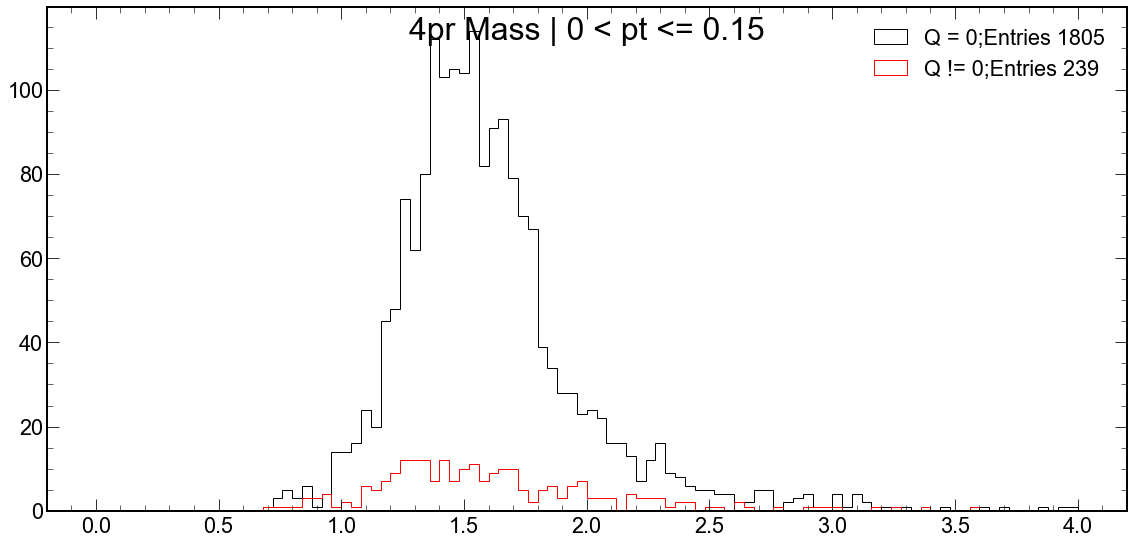

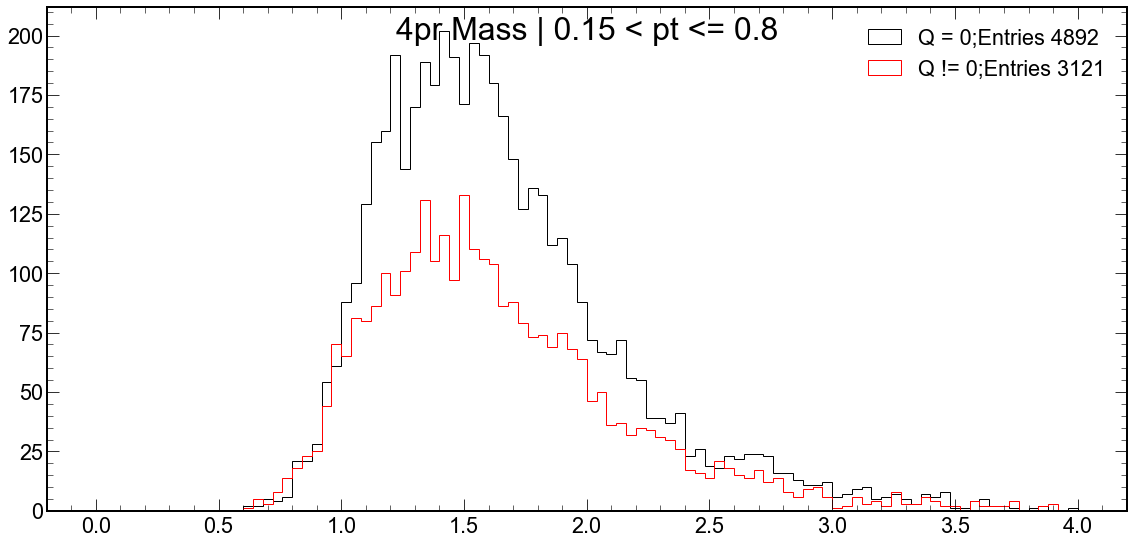

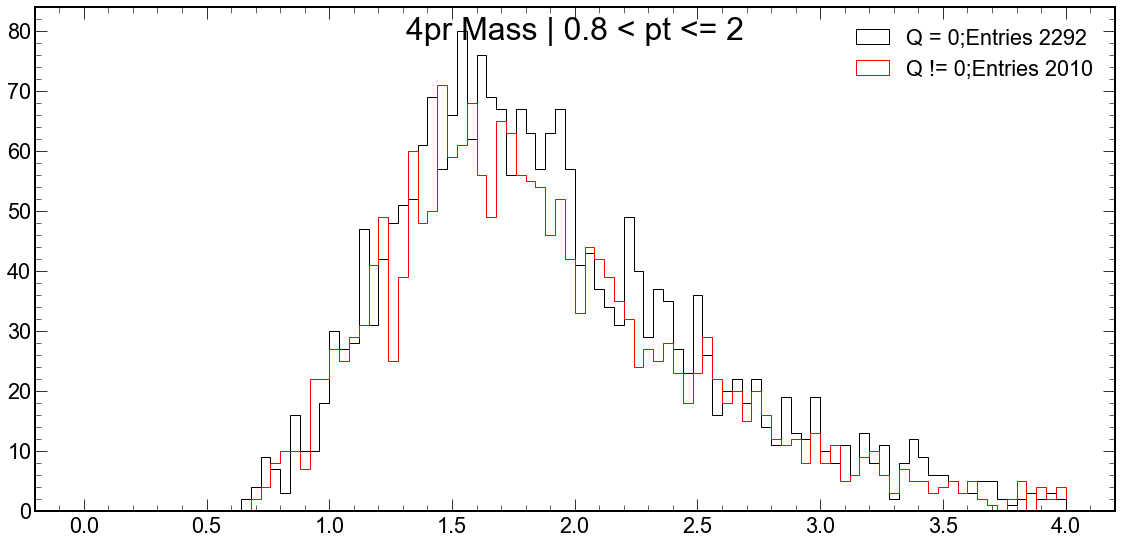

In [211]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'4pr Mass | {0} < pt <= {0.15}', fontsize=32)
plt.style.use(hep.style.ROOT)
GoodEvents = GetGoodEvents()
counts, bins = np.histogram(GetMass(Draw=False), bins=100, range=(0,4))
_ = ax.hist(GetMass(Draw=False), bins=bins, color='black', histtype='step', label=f'Q = 0;Entries {np.sum(counts)}')
GoodEvents = GetGoodEvents(ChargeEqualCondition=False)
counts, bins = np.histogram(GetMass(ChargeEqualCondition=False,Draw=False), bins=100, range=(0,4))
_ = ax.hist(GetMass(ChargeEqualCondition=False,Draw=False), bins=bins, color='red', histtype='step', label=f'Q != 0;Entries {np.sum(counts)}')
ax.legend()

fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'4pr Mass | {0.15} < pt <= {0.8}', fontsize=32)
plt.style.use(hep.style.ROOT)
GoodEvents = GetGoodEvents()
counts, bins = np.histogram(GetMass(Draw=False, ptMin=0.15, ptMax=0.8), bins=100, range=(0,4))
_ = ax.hist(GetMass(Draw=False,ptMin=0.15, ptMax=0.8), bins=bins, color='black', histtype='step', label=f'Q = 0;Entries {np.sum(counts)}')
GoodEvents = GetGoodEvents(ChargeEqualCondition=False)
counts, bins = np.histogram(GetMass(ChargeEqualCondition=False,Draw=False,ptMin=0.15, ptMax=0.8), bins=100, range=(0,4))
_ = ax.hist(GetMass(ChargeEqualCondition=False,Draw=False,ptMin=0.15, ptMax=0.8), bins=bins, color='red', histtype='step', label=f'Q != 0;Entries {np.sum(counts)}')
ax.legend()

fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'4pr Mass | {0.8} < pt <= {2}', fontsize=32)
plt.style.use(hep.style.ROOT)
GoodEvents = GetGoodEvents()
counts, bins = np.histogram(GetMass(Draw=False, ptMin=0.8, ptMax=2), bins=100, range=(0,4))
_ = ax.hist(GetMass(Draw=False,ptMin=0.8, ptMax=2), bins=bins, color='black', histtype='step', label=f'Q = 0;Entries {np.sum(counts)}')
GoodEvents = GetGoodEvents(ChargeEqualCondition=False)
counts, bins = np.histogram(GetMass(ChargeEqualCondition=False,Draw=False,ptMin=0.8, ptMax=2), bins=100, range=(0,4))
_ = ax.hist(GetMass(ChargeEqualCondition=False,Draw=False,ptMin=0.8, ptMax=2), bins=bins, color='red', histtype='step', label=f'Q != 0;Entries {np.sum(counts)}')
ax.legend()



## Estimation of TPC influence


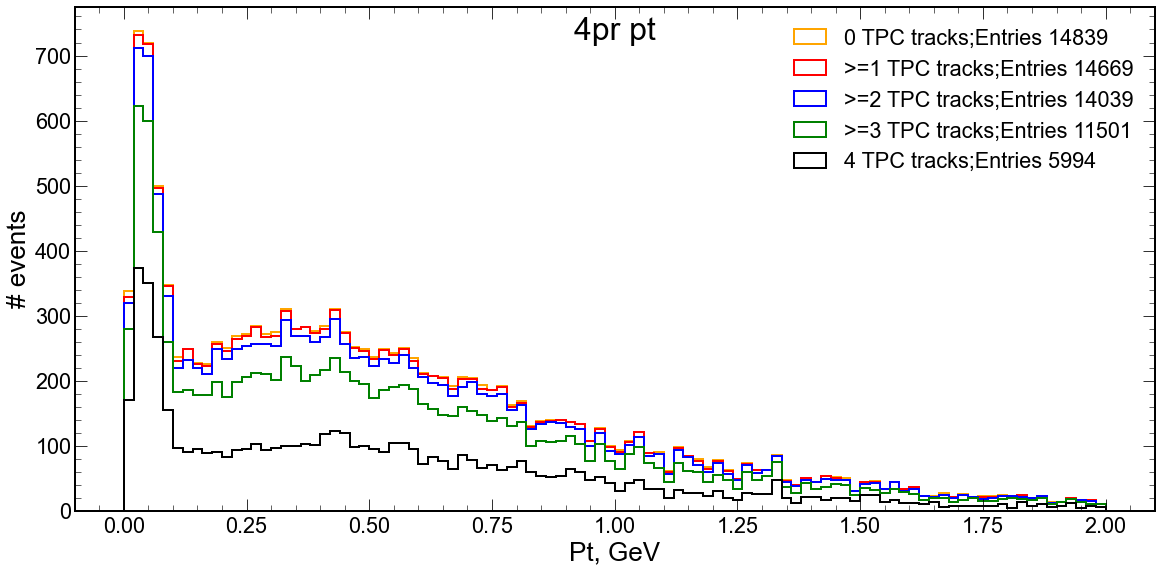

In [29]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'4pr pt', fontsize=32)
plt.style.use(hep.style.ROOT)

GoodEvents = GetGoodEvents()
counts, bins = np.histogram(GetPt(Draw=False), bins=100, range=(0,2))
_ = ax.hist(GetPt(Draw=False), bins=bins, color='orange', histtype='step', label=f'0 TPC tracks;Entries {np.sum(counts)}', linewidth=2)

GoodEvents = GetGoodEvents(WithGoodNTpcTracks=1)
counts, bins = np.histogram(GetPt(Draw=False), bins=100, range=(0,2))
_ = ax.hist(GetPt(Draw=False), bins=bins, color='red', histtype='step', label=f'>=1 TPC tracks;Entries {np.sum(counts)}', linewidth=2)

GoodEvents = GetGoodEvents(WithGoodNTpcTracks=2)
counts, bins = np.histogram(GetPt(Draw=False), bins=100, range=(0,2))
_ = ax.hist(GetPt(Draw=False), bins=bins, color='blue', histtype='step', label=f'>=2 TPC tracks;Entries {np.sum(counts)}', linewidth=2)

GoodEvents = GetGoodEvents(WithGoodNTpcTracks=3)
counts, bins = np.histogram(GetPt(Draw=False), bins=100, range=(0,2))
_ = ax.hist(GetPt(Draw=False), bins=bins, color='green', histtype='step', label=f'>=3 TPC tracks;Entries {np.sum(counts)}', linewidth=2)

GoodEvents = GetGoodEvents(WithGoodNTpcTracks=4)
counts, bins = np.histogram(GetPt(Draw=False), bins=100, range=(0,2))
_ = ax.hist(GetPt(Draw=False), bins=bins, color='black', histtype='step', label=f'4 TPC tracks;Entries {np.sum(counts)}', linewidth=2)
plt.xlabel('Pt, GeV')
plt.ylabel('# events')
ax.legend()

сделать линии толще
план
    рассказываю отбор
    цель 
    вывод влияние  
        2трека без tpc заметно увеличивает статистику
        планы
        проверить корректность триггера: обеспечен ли триггер фасторами от наших треков(а не от фейков)
        

## Energy losses

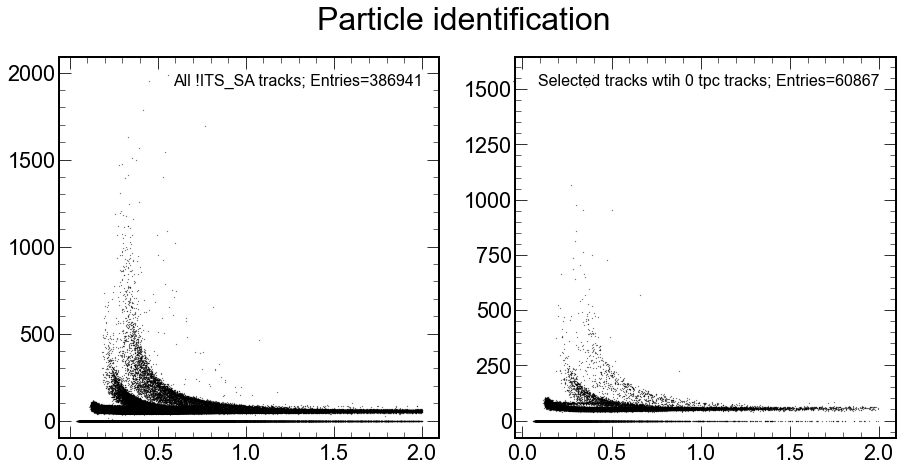

In [31]:
pt = np.sqrt(data['T_Px']**2 + data['T_Py']**2)
dedx = data['TPCsignal'][(pt<2)].flatten()
pt = pt[pt<2].flatten()

fig, ax = plt.subplots(1,2,figsize=(15, 7))
fig.suptitle(f'Particle identification', fontsize=32)
plt.style.use(hep.style.ROOT)
ax[0].scatter(pt, dedx, s=0.05, color='black', label=f'All !ITS_SA tracks; Entries={len(dedx)}')
ax[0].legend(loc=1, prop={'size': 16})

NTPCTracks = 0
GoodEvents = GetGoodEvents(WithGoodNTpcTracks=NTPCTracks)
ptTracks = np.sqrt(data['T_Px']**2 + data['T_Py']**2)[select][GoodEvents]
dedx = data['TPCsignal'][select][GoodEvents][ptTracks<2].flatten()
ptTracks = ptTracks[ptTracks<2]
ax[1].scatter(ptTracks.flatten(), dedx.flatten(), s=0.05, color = 'black',label=f'Selected tracks wtih {NTPCTracks} tpc tracks; Entries={len(dedx)}')
ax[1].legend(loc=1, prop={'size': 16})


# Debug

In [16]:
import pandas as pd

def ShowTracks(n, AllTracksInEvent=False):

    df = events.pandas.df(["T_Q", "T_P[xyz]", "*Cls", "*Refit", "RunNum", "PeriodNumber",\
                           "OrbitNumber","BunchCrossNumber", "T_Dca1", "T_Dca0", \
                           "T_NumberOfSigmaTPCPion"], entrystart=n, entrystop=n+1)
    
    df.insert(0, "Selected", select[n])
    pxg = data['T_Px'][select][n]
    pyg = data['T_Py'][select][n]
    
    pt = np.sqrt(pxg.sum()**2  + pyg.sum()**2)
    df.insert(4, "Pt", pt)

    if AllTracksInEvent:
        display(df)
    else:
        display(df[df['Selected']])

GoodEvents = GetGoodEvents(WithGoodNTpcTracks=4)
print("Selected events list: \n", GoodEvents[300:350])
n=2766 #16385
ShowTracks(n, AllTracksInEvent=True)
select[n]

Selected events list: 
 [2766 2767 2777 2786 2791 2801 2807 2827 2841 2843 2857 2883 2893 2899
 2908 2911 2985 2986 2997 3005 3031 3033 3039 3056 3063 3065 3071 3099
 3102 3110 3126 3155 3156 3158 3170 3171 3202 3218 3242 3246 3252 3266
 3281 3292 3303 3308 3311 3312 3326 3335]


Selected  T_Q      T_Px      T_Py        Pt      T_Pz  \
entry subentry                                                          
2766  0             True    1  0.323357  0.247585  0.161809  0.273582   
      1             True   -1 -0.406583 -0.247494  0.161809  0.445707   
      2             True    1  0.067792  0.274404  0.161809  0.278095   
      3             True   -1 -0.128154 -0.349092  0.161809  0.360014   

                T_TPCNCls  T_ITSNCls  T_TPCRefit  T_ITSRefit  RunNum  \
entry subentry                                                         
2766  0               152          5        True        True  246493   
      1               128          6        True        True  246493   
      2               130          4        True        True  246493   
      3               126          5        True        True  246493   

                PeriodNumber  OrbitNumber  BunchCrossNumber    T_Dca1  \
entry subentry                                                          
2766  0                    1      9559610              1735  0.008932   
      1                    1      9559610              1735  0.000403   
      2                    1      9559610              1735 -0.090921   
      3                    1      9559610              1735 -0.005738   

                  T_Dca0  T_NumberOfSigmaTPCPion  
entry subentry                                    
2766  0         0.005671               -0.022445  
      1        -0.013817               -0.466878  
      2         0.061770               -0.975210  
      3         0.048228                0.023058

array([ True,  True,  True,  True])

3681 6005


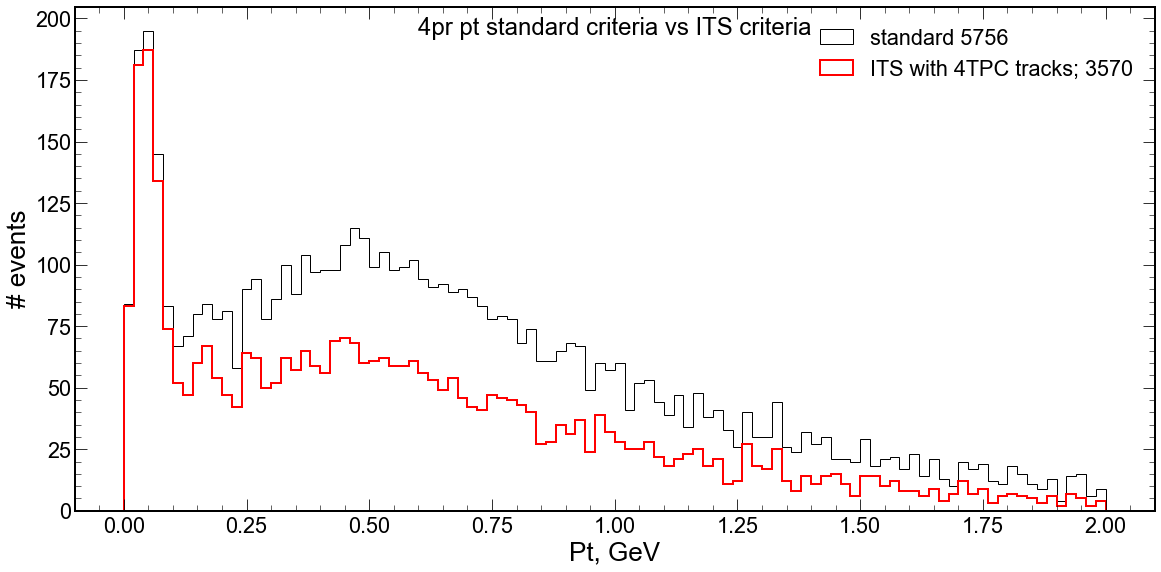

In [5]:
selectOnlyStandard    = data['T_TPCRefit']  * (data['T_TPCNCls'] > 50) * \
            (data['T_ITSNCls'] > 3) * \
            (~newT_ITSsa) * (np.abs(data['T_NumberOfSigmaTPCPion']) < 3)
GoodEventsStandard = np.argwhere(selectOnlyStandard.sum()==4).flatten() # get events with 4 good tracks
GoodEventsStandard = GoodEventsStandard[np.argwhere(data['T_Q'][selectOnlyStandard][GoodEventsStandard].sum()==0).flatten()].flatten()  

pxstd = data['T_Px'][selectOnlyStandard][GoodEventsStandard]
pystd = data['T_Py'][selectOnlyStandard][GoodEventsStandard]
    
ptstd = np.sqrt(pxstd.sum()**2  + pystd.sum()**2)

fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'4pr pt standard criteria vs ITS criteria', fontsize=24)
plt.style.use(hep.style.ROOT)
counts, bins = np.histogram(ptstd, bins=100, range=(0,2))
_ = ax.hist(ptstd, bins=bins, color='black', histtype='step', label=f'standard {np.sum(counts)}')
plt.xlabel('Pt, GeV')
plt.ylabel('# events')
ax.legend()

GoodEvents = GetGoodEvents(WithGoodNTpcTracks=4)
counts, bins = np.histogram(GetPt(Draw=False), bins=100, range=(0,2))
_ = ax.hist(GetPt(Draw=False), bins=bins, color='red', histtype='step', label=f'ITS with 4TPC tracks; {np.sum(counts)}', linewidth=2)
plt.xlabel('Pt, GeV')
plt.ylabel('# events')
ax.legend()

print(len(GoodEvents), len(GoodEventsStandard))

2527 146


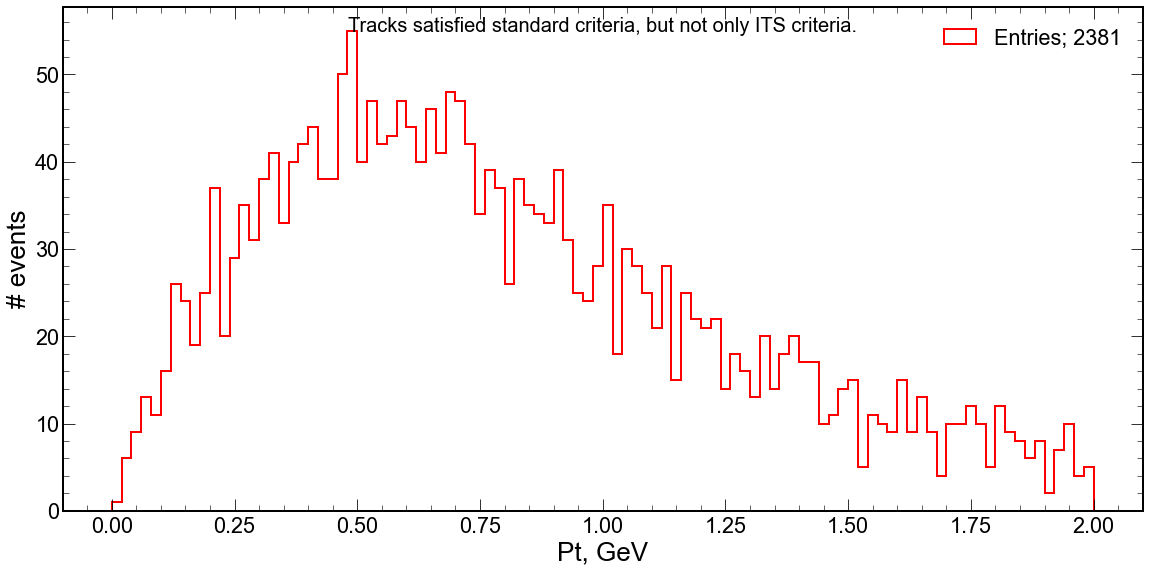

In [22]:
diff = list(set(GoodEventsStandard) - set(GoodEvents))

pxg = data['T_Px'][selectOnlyStandard][diff]
pyg = data['T_Py'][selectOnlyStandard][diff]
    
pt = np.sqrt(pxg.sum()**2  + pyg.sum()**2)

print(len(pt),(pt > 2).sum())

fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'Tracks satisfied standard criteria, but not only ITS criteria.', fontsize=20)
plt.style.use(hep.style.ROOT)
counts, bins = np.histogram(pt, bins=100, range=(0,2))
_ = plt.hist(pt, bins=bins, color='red', histtype='step', label=f'Entries; {np.sum(counts)}', linewidth=2)
plt.xlabel('Pt, GeV')
plt.ylabel('# events')
ax.legend()
# 2186

## Valeri comparison

In [17]:
# Valeri data
valeri = pd.read_csv(r"D:\GoogleDrive\Job\cern\Alice\analysis\dev\pvn\log",header=None, delimiter=' ',  \
                     names=["RunNum", "PeriodNumber", "OrbitNumber", "BunchCrossNumber", "Pt"])
valeri

,RunNum,PeriodNumber,OrbitNumber,BunchCrossNumber,Pt
0,245683,3,10703439,1564,0.044254
1,245683,3,3228506,525,0.050910
2,245683,3,4050265,2311,0.139421
3,245683,3,2449154,19,0.054850
4,245683,3,15437718,1971,0.044654
...,...,...,...,...,...
2312,246994,3,4530108,552,0.036294
2313,246994,2,1128919,1353,0.033302
2314,246994,3,11883250,8,0.088530
2315,246994,1,9386270,989,0.020394


In [65]:
# my data
GoodEvents = GetGoodEvents()

pxg = data['T_Px'][select][GoodEvents]
pyg = data['T_Py'][select][GoodEvents]
pt = np.sqrt(pxg.sum()**2  + pyg.sum()**2)

RunNum = data['RunNum'][GoodEvents][pt<0.15]
PeriodNumber = data['PeriodNumber'][GoodEvents][pt<0.15]
OrbitNumber = data['OrbitNumber'][GoodEvents][pt<0.15]
BunchCrossNumber = data['BunchCrossNumber'][GoodEvents][pt<0.15]
dd = {"RunNum" : RunNum, "PeriodNumber":PeriodNumber, "OrbitNumber":OrbitNumber, "BunchCrossNumber":BunchCrossNumber}
myData = pd.DataFrame(dd)

pt = pt[pt<0.15]
myData.insert(4, "Pt", pt)
myData
print(len(pt))
myData

29


,RunNum,PeriodNumber,OrbitNumber,BunchCrossNumber,Pt
0,246148,1,5501212,3356,0.085881
1,246148,4,4852140,2363,0.070132
2,246148,1,8223084,3393,0.071142
3,246148,4,882013,1117,0.087816
4,246148,2,8627494,2531,0.042815
5,246148,4,10536151,3499,0.055536
6,246148,5,13930190,1091,0.051965
7,246148,5,15974090,3049,0.055724
8,246148,4,440214,2169,0.076759
9,246148,3,15790899,2363,0.032535


In [45]:
val = valeri['RunNum'].to_numpy(dtype=np.int)
my = myData['RunNum'].to_numpy(dtype=np.int)

print(min(val), max(val), max(val) - min(val))
print(min(my), max(my), max(my) - min(my))
totalRunNUmbers = np.unique(list(val) + (list(my)))
valDict = {}
myDict = {}
for r in totalRunNUmbers:
    valDict[r] = 0
    myDict[r] = 0
    
for v in val:
    valDict[v] +=1
    
for v in my:
    myDict[v] +=1
    
x = np.arange(len(totalRunNUmbers))  # the label locations
width = 0.15  # the width of the bars

# fig, ax = plt.subplots(figsize=(150, 30))
# rects1 = ax.bar(x - width/2, valDict.values(), width, label='Valeri')
# rects2 = ax.bar(x + width/2, myDict.values(), width, label='Boris')
# ax.set_ylabel('#Events')
# ax.set_title('')
# ax.set_xticks(x)
# ax.set_xticklabels(totalRunNUmbers,rotation=90)
# ax.legend()

# plt.show()

print(valDict[246087])
print(myDict[246148])

245683 246994 1311
245145 246994 1849
169
169


In [461]:
valArr = valeri.loc[:,'RunNum':'BunchCrossNumber'].to_numpy(dtype=np.int)
myArr = myData.loc[:,'RunNum':'BunchCrossNumber'].to_numpy(dtype=np.int)
valArr_rows = set(map(tuple, valArr))
myArr_rows = set(map(tuple, myArr))
print(len(valArr_rows.difference(myArr_rows)), len(myArr_rows.difference(valArr_rows)))

valArr_rows.intersection(myArr_rows)
OnlyValeri = []
for v in valArr_rows.difference(myArr_rows):
    l = list(v)
    l.append(valeri['Pt'][valeri['RunNum'] == v[0]]\
             [valeri['PeriodNumber'] == v[1]]\
             [valeri['OrbitNumber'] == v[2]]\
             [valeri['BunchCrossNumber'] == v[3]].values[0])
    OnlyValeri.append(tuple(l))

OnlyBoris = []
for v in myArr_rows.difference(valArr_rows):
    l = list(v)
    l.append(myData['Pt'][myData['RunNum'] == v[0]] \
             [myData['PeriodNumber'] == v[1]] \
             [myData['OrbitNumber'] == v[2]] \
             [myData['BunchCrossNumber'] == v[3]].values[0])
    OnlyBoris.append(tuple(l))    

1286 999


In [482]:
print(len(OnlyValeri),len(OnlyBoris))
OnlyBoris[-2]
# with open('OnlyBorisEvents', 'w') as fp:
#       fp.write('\n'.join('{} {} {} {} {}'.format(x[0],x[1],x[2],x[3],x[4]) for x in OnlyBoris))

1286 999


(245347, 2, 5419309, 1997, 0.05885924)

In [55]:
exist = 0
sel = []
ns = []
for n in range(len(OnlyValeri)):
#     n= 41
    inptuple = OnlyValeri[n]
#     print(n, inptuple)
    if inptuple[0] != 246148:
        continue
    evNum = np.argwhere((data['RunNum']==inptuple[0]) * \
                   (data['PeriodNumber']==inptuple[1]) * \
                   (data['OrbitNumber']==inptuple[2]) * \
                   (data['BunchCrossNumber']==inptuple[3]) \
                   ).flatten()

#   print(evNum)
    if len(evNum) > 0:
        exist += 1
        ns.append(n)
#         if (~newT_ITSsa[evNum[0]]).sum() == 4:
        print (n, evNum)
        ShowTracks(evNum[0], AllTracksInEvent=True)
print(exist)


NameError: name 'OnlyValeri' is not defined

In [54]:
exist = 0
sel = []
ns = []
# for n in range(len(OnlyValeri)):
#     n= 41
inptuple = (246148,4,4852140,2363)# OnlyValeri[n]
#     print(n, inptuple)

evNum = np.argwhere((data['RunNum']==inptuple[0]) * \
                   (data['PeriodNumber']==inptuple[1]) * \
                   (data['OrbitNumber']==inptuple[2]) * \
                   (data['BunchCrossNumber']==inptuple[3]) \
                   ).flatten()
print(evNum)
ShowTracks(evNum[0], AllTracksInEvent=True)

[10]


Selected  T_Q      T_Px      T_Py        Pt      T_Pz  \
entry subentry                                                          
10    0             True   -1  0.017924  0.256082  0.070133 -0.141640   
      1             True    1  0.187887  0.162127  0.070133  0.036663   
      2             True   -1 -0.012474 -0.586373  0.070133  0.207274   
      3             True    1 -0.153283  0.110596  0.070133 -0.070528   

                T_TPCNCls  T_ITSNCls  T_TPCRefit  T_ITSRefit  RunNum  \
entry subentry                                                         
10    0               148          5        True        True  246148   
      1               145          5        True        True  246148   
      2               138          5        True        True  246148   
      3                 0          6       False        True  246148   

                PeriodNumber  OrbitNumber  BunchCrossNumber    T_Dca1  \
entry subentry                                                          
10    0                    4      4852140              2363  0.032149   
      1                    4      4852140              2363 -0.045336   
      2                    4      4852140              2363  0.022129   
      3                    4      4852140              2363 -0.000443   

                  T_Dca0  T_NumberOfSigmaTPCPion  
entry subentry                                    
10    0         0.042990               -0.210811  
      1         0.018947               -1.646637  
      2        -0.000632               -0.137152  
      3         0.014046             -999.000000

In [52]:
len(data['RunNum'])

695